<a href="https://colab.research.google.com/github/giramos/Machine-Learning/blob/master/Sesion01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje automático - Sesión 01
## 1 - Algoritmos vecinos más cercanos

¿Cuádo nos puede resultar útil k-nn?

In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/datos01_train.csv")

Visualizar un conjunto de datos (funcion)

In [9]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

colors = {0: "#4A249D", 1: "#0D7C66"}

def visualizar_datos(df_datos: pd.DataFrame, df_labels: pd.DataFrame, title: str, x_label: str, y_label: str, legend_dict: dict = None, new_point: np.ndarray = None) -> tuple:
    if isinstance(df_datos, pd.DataFrame):
        df_datos = df_datos.to_numpy()

    if isinstance(df_labels, pd.DataFrame):
        df_labels = df_labels.to_numpy()

    fig, ax = plt.subplots(figsize=(5,5))

    # Visualizar los puntos de entrenamiento
    ax.scatter(df_datos[:, 0], df_datos[:, 1], c=[colors[c] for c in df_labels],
        s=100,
        edgecolor="k",
    )

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

    if new_point is not None:
        ax.scatter(new_point[0], new_point[1], color="red", marker="*", s=200, label="Nueva persona")

    if legend_dict is not None:
        legend_elements = [
            Line2D([0], [0], marker="o", color="w", markerfacecolor=colors[0], markersize=10, label=legend_dict[0]),
            Line2D([0], [0], marker="o", color="w", markerfacecolor=colors[1], markersize=10, label=legend_dict[1]),
        ]

        if new_point is not None:
            legend_elements.append(Line2D([0], [0], marker="*", color="w", markerfacecolor="red", markersize=10, label="Nuevo punto"))

        plt.legend(handles=legend_elements)

    plt.show()

    return ax.get_xlim(), ax.get_ylim()

Visualizar un conjunto de datos (resultado)

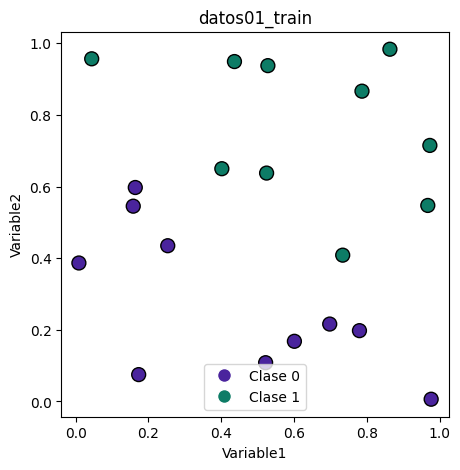

In [10]:
x_range, y_range =  visualizar_datos(df.iloc[:,:-1], df.iloc[:,-1], "datos01_train", "Variable1", "Variable2", {0: "Clase 0", 1: "Clase 1"})

### 1.1 Implementando k-nn
Distancia Euclidea (funcion)

In [11]:
def euclidean_distance(x, y):
    # 1. Restamos los arrays x e y elemento por elemento
    # 2. Elevamos al cuadrado cada una de las n diferencias
    # 3. np.sum suma todos los elementos resultantes
    # 4. np.sqrt calcula la raíz cuadrada de la suma
    return np.sqrt(np.sum((x - y)**2))

Calcular las distancias euclideas

In [12]:
# Tres personas de ejemplo
per_1 = np.array([70, 180])
per_2 = np.array([70, 170])
per_3 = np.array([80, 180])
print(f"La distancia Euclídea entre la persona 1 y la 2 es {euclidean_distance(per_1, per_2):.2f}")
print(f"La distancia Euclídea entre la persona 1 y la 3 es {euclidean_distance(per_1, per_3):.2f}")

La distancia Euclídea entre la persona 1 y la 2 es 10.00
La distancia Euclídea entre la persona 1 y la 3 es 10.00


Otro ejemplo con mas variables

In [13]:
# Dos puntos de ejemplo
punto_a = np.array([0.4, 0.5, 0.1, 0.3, 0.5])
punto_b = np.array([0.8, 0.7, 0.2, 0.8, 0.2])
print(f"La distancia Euclídea entre A y B es {euclidean_distance(punto_a, punto_b):.2f}")

La distancia Euclídea entre A y B es 0.74


Definimos la clase k-NN

In [14]:
from typing import Callable

class KNN:
    def __init__(self, k: int, dist_func: Callable[[float, float], float]) -> None:
        self.k = k
        self.dist_func = dist_func

    # Guardar los datos de entrenamiento
    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.to_numpy()

        if isinstance(y_train, pd.DataFrame):
            y_train = y_train.to_numpy()

        self.X_train = X_train
        self.y_train = y_train

    # Calcular distancias del nuevo punto a cada punto de entrenamiento
    def compute_distances(self, X_new: np.ndarray) -> None:
        return np.array([self.dist_func(X_new, x_train) for x_train in self.X_train])

    # Encontrar los índices de los k vecinos más cercanos
    def nearest_neighbors_idx(self, X_new: np.ndarray) -> None:
        distances = self.compute_distances(X_new)
        return np.argsort(distances)[: self.k]

    # Predecir la clase del nuevo punto
    def predict(self, X_new: np.ndarray) -> None:
        # Obtener las clases de los k vecinos más cercanos
        nearest_neighbors_classes = self.y_train[self.nearest_neighbors_idx(X_new)]

        # Predecir la clase por la mayoría de los vecinos
        return np.bincount(nearest_neighbors_classes).argmax()

### 1.3 Usando k-NN
Cargamos los datos de entrenamiento y visualizamos los datos

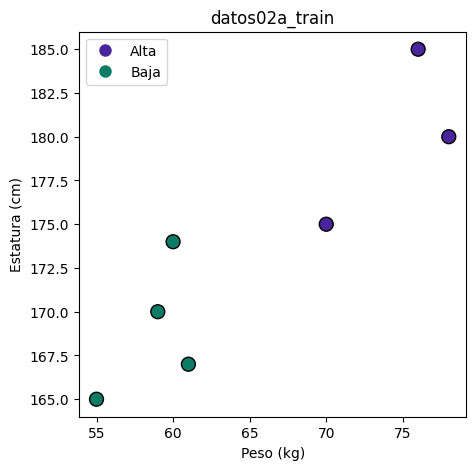

In [19]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/datos02a_train.csv")

# Separar las variables (X) de las etiquetas (y)
X_train = df[["Peso", "Estatura"]]
y_train = df["ActividadFisica"]

dict_clases = {0: "Alta", 1: "Baja"}

x_range, y_range = visualizar_datos(X_train, y_train, "datos02a_train", "Peso (kg)", "Estatura (cm)", dict_clases)

Vamos a aplicar el algoritmo con k=3

Codigo de la clase Animate

In [20]:
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Button


class AnimateKNN:
    def __init__(self, knn: KNN, X_new: np.ndarray, colors: dict, col_names_train: list, class_name: str) -> None:
        if isinstance(X_new, pd.DataFrame):
            X_new = X_new.to_numpy()

        # Configurar la figura y los ejes
        self.fig, self.ax = plt.subplots(figsize=(8, 6))
        self.knn = knn
        self.X_new = X_new
        self.colors = colors
        self.default_x_new_color = "red"
        self.is_animated = False
        self.circles = []
        self.current_frame = -2
        self.max_frame = 2 + len(self.knn.X_train) + 3
        self.col_names_train = col_names_train
        self.class_name = class_name

        # Configuración del propio gráfico
        self.__configure_chart()

        # Visualizar los puntos de entrenamiento
        self.scatter_train = self.ax.scatter(
            self.knn.X_train[:, 0],
            self.knn.X_train[:, 1],
            c=[self.colors[c] for c in self.knn.y_train],
            s=100,
            edgecolor="k",
        )

        # Visualizar el nuevo punto como una estrella al principio
        self.scatter_new = self.ax.scatter(
            [], [], color=self.default_x_new_color, marker="*", s=200, label="Nuevo punto"
        )

        # Lineas que conectarán el nuevo punto con los puntos de entrenamiento
        self.lines = [self.ax.plot([], [], "k--", linewidth=1)[0] for _ in range(len(self.knn.X_train))]
        self.texts = [self.ax.text(0, 0, "", fontsize=12) for _ in range(len(self.knn.X_train))]

        # Obtener predicciones del punto nuevo
        self.distances = self.knn.compute_distances(X_new=self.X_new)
        self.nearest_neighbors_idx = self.knn.nearest_neighbors_idx(X_new=self.X_new)
        self.predicted_class = self.knn.predict(X_new=self.X_new)

        # Crear la animación
        self.ani = FuncAnimation(self.fig, self.auto_update, frames=self.max_frame + 1, interval=1000, repeat=True)
        self.ani.pause()  # Detener la animación automática al principio

        # Botón para avanzar paso a paso manualmente
        ax_button_next = plt.axes([0.58, 0.01, 0.1, 0.05])
        self.button_next = Button(ax_button_next, "Siguiente")

        # Botón para ejecutar la secuencia completa
        ax_button_run = plt.axes([0.69, 0.01, 0.1, 0.05])
        self.button_run = Button(ax_button_run, "Ejecutar")

        # Botón para resetear la animación
        ax_button_reset = plt.axes([0.80, 0.01, 0.1, 0.05])
        self.button_reset = Button(ax_button_reset, "Reset")

        # Conectar los botones con las funciones correspondientes
        self.button_next.on_clicked(self.next_step)
        self.button_run.on_clicked(self.run_sequence)
        self.button_reset.on_clicked(self.reset)

    def __configure_chart(self) -> None:
        self.ax.grid(True)
        self.ax.set_axisbelow(True)
        self.ax.set_xlabel(self.col_names_train[0])
        self.ax.set_ylabel(self.col_names_train[1])
        self.fig.suptitle(f"{self.knn.k}-NN: {self.class_name} según {self.col_names_train[0]} y {self.col_names_train[1]}")

        legend_elements = [
            Line2D([0], [0], marker="o", color="w", markerfacecolor=self.colors[0], markersize=10, label="Alta"),
            Line2D([0], [0], marker="o", color="w", markerfacecolor=self.colors[1], markersize=10, label="Baja"),
            Line2D([0], [0], marker="*", color="w", markerfacecolor="red", markersize=15, label="Nueva persona"),
        ]
        plt.legend(handles=legend_elements)

    # Método para actualizar la animación en cada frame
    def update(self, frame: int) -> None:
        if frame == 0:
            # Paso 1: Gráfico inicial con los 5 puntos del dataset
            self.ax.set_title("Dataset de entrenamiento", fontsize=10, color="gray", pad=11)
            self.scatter_new.set_offsets(np.empty((0, 2)))  # No mostrar el nuevo punto aún
            for line, text in zip(self.lines, self.texts):
                line.set_data([], [])
                text.set_text("")

        elif frame == 1:
            # Paso 2: Visualizar el punto a predecir
            self.ax.set_title("Queremos predecir una nueva persona", fontsize=10, color="gray", pad=11)
            self.scatter_new.set_offsets(self.X_new)

        elif 2 <= frame < 2 + len(self.knn.X_train):
            # Paso 3: Dibujar lineas discontinuas y mostrar las distancias
            self.ax.set_title(
                "Comprobamos distancias a todas las personas de entrenamiento", fontsize=10, color="gray", pad=11
            )
            idx = frame - 2
            self.lines[idx].set_data(
                [self.X_new[0], self.knn.X_train[idx][0]], [self.X_new[1], self.knn.X_train[idx][1]]
            )
            self.texts[idx].set_position(
                ((self.X_new[0] + self.knn.X_train[idx][0]) / 2, (self.X_new[1] + self.knn.X_train[idx][1]) / 2)
            )
            self.texts[idx].set_text(f"{self.distances[idx]:.2f}")

        elif frame == 2 + len(self.knn.X_train):
            # Paso 4: Quedarse solo con las 3 líneas con menor distancia
            self.ax.set_title("Nos quedamos con lo k-vecinos más cercanos", fontsize=10, color="gray", pad=11)
            for i in range(len(self.knn.X_train)):
                if i not in self.nearest_neighbors_idx:
                    self.lines[i].set_data([], [])  # Eliminar líneas que no sean de los 3 vecinos más cercanos
                    self.texts[i].set_text("")  # Eliminar el texto asociado
                else:
                    self.circles.append(
                        self.ax.scatter(
                            self.knn.X_train[i][0],
                            self.knn.X_train[i][1],
                            facecolors="none",
                            edgecolors="#D91656",
                            s=300,
                            linewidth=2,
                        )
                    )

        elif frame == 2 + len(self.knn.X_train) + 1:
            # Paso 4.a: Quitar las líneas de los vecinos con la clase minoritaria
            self.ax.set_title("Buscamos la clase mayoritaria", fontsize=10, color="gray", pad=11)
            for i in self.nearest_neighbors_idx:
                if self.knn.y_train[i] != self.predicted_class:
                    self.lines[i].set_data([], [])  # Eliminar líneas de vecinos de clase minoritaria
                    self.texts[i].set_text("")  # Eliminar el texto asociado

        elif frame == 2 + len(self.knn.X_train) + 2:
            # Paso 5: Cambiar el punto a predecir de estrella a un punto de color de la clase mayoritaria
            self.ax.set_title("Se predice la clase mayoritaria", fontsize=10, color="gray", pad=11)
            self.scatter_new.set_offsets([self.X_new])
            self.scatter_new.set_color(self.colors[self.predicted_class])

        elif frame == self.max_frame:
            # Paso 6: Quitar todas las líneas
            for line in self.lines:
                line.set_data([], [])
            for text in self.texts:
                text.set_text("")

    # Método para avanzar al siguiente paso manualmente
    def next_step(self, event):
        if self.current_frame < self.max_frame:
            self.current_frame += 1
            self.update(self.current_frame)

    # Método para ejecutar la secuencia completa automáticamente
    def run_sequence(self, event):
        self.is_animated = True

        if self.current_frame < self.max_frame:
            self.ani.resume()

    # Método para resetear la animación y volver al estado inicial
    def reset(self, event):
        self.current_frame = -2
        self.update(self.current_frame)

        self.scatter_new.set_offsets(np.empty((0, 2)))  # Ocultar el nuevo punto
        self.scatter_new.set_color(self.default_x_new_color)

        for circle in self.circles:
            circle.remove()
        self.circles = []

        for line, text in zip(self.lines, self.texts):
            line.set_data([], [])
            text.set_text("")

        self.ani.pause()  # Pausar la animación
        self.is_animated = False

    # Método para controlar el flujo automático con FuncAnimation
    def auto_update(self, frame):
        if self.is_animated and self.current_frame < self.max_frame:
            self.current_frame += 1
            self.update(self.current_frame)

        if self.current_frame == self.max_frame:
            self.ani.pause()  # Detener la animación al final
            self.is_animated = False

    # Método para exportar a HTML, eliminando los botones porque ahora no son necesarios
    def to_jshtml(self) -> str:
        self.is_animated = True
        self.__remove_buttons()
        return self.ani.to_jshtml()

    def __remove_buttons(self) -> None:
        self.button_next.ax.remove()
        self.button_run.ax.remove()
        self.button_reset.ax.remove()

    # Método para actualizar la gráfica en un frame específico sin animación
    def plot_at_frame(self, frame_fix: int) -> None:
        if frame_fix < self.max_frame:
            for i in range(frame_fix + 1):
                self.update(i)

        self.__remove_buttons()
        plt.show()

Vamos a aplicar el algoritmo con **k=3**

In [21]:
from IPython.display import HTML

X_new = np.array([68, 170]) # Nueva persona a clasificar

# Crear el modelo
model = KNN(k=3, dist_func=euclidean_distance)

# Entrenar el modelo (en KNN consiste solo en guardar los datos de entrenamiento)
model.fit(X_train=X_train, y_train=y_train)

ani_knn_1 = AnimateKNN(knn=model, X_new=X_new, colors=colors, col_names_train=["Peso (kg)", "Estatura (cm)"], class_name="Actividad Física")
plt.close()
HTML(ani_knn_1.to_jshtml())

*Pregunta*: ¿Qué ocurre si solo utilizamos el vecino más cercano **k=1**?

> Que solo mostrará un vecino



In [22]:
from IPython.display import HTML

X_new = np.array([68, 170])  # Nueva persona a clasificar

# Crear el modelo con k=1
model = KNN(k=1, dist_func=euclidean_distance)

# Entrenar el modelo (en KNN consiste solo en guardar los datos de entrenamiento)
model.fit(X_train=X_train, y_train=y_train)

ani_knn_1 = AnimateKNN(
    knn=model,
    X_new=X_new,
    colors=colors,
    col_names_train=["Peso (kg)", "Estatura (cm)"],
    class_name="Actividad Física",
)
plt.close()
HTML(ani_knn_1.to_jshtml())

# 2 La librería sklearn
## 2.1 Reproduciendo el ejemplo anterior

In [24]:
from sklearn.neighbors import KNeighborsClassifier

# Nuestro modelo
model = KNN(k=3, dist_func=euclidean_distance) # Crear modelo

model.fit(X_train=X_train, y_train=y_train) # Entrenar el modelo

predicted_class_propio = model.predict([X_new]) # Predecir la clase de la nueva persona

# Modelo de sklearn
model_sklearn = KNeighborsClassifier(n_neighbors=3) # Crear modelo

model_sklearn.fit(X_train, y_train) # Entrenar el modelo

predicted_class_sklearn = model_sklearn.predict([X_new]) # Predecir la clase de la nueva persona

print(f"La nueva persona es {dict_clases[predicted_class_sklearn[0]]} (sklearn)") # Ojo: retorna array
print(f"La nueva persona es {dict_clases[predicted_class_propio]} (propio)")

La nueva persona es Baja (sklearn)
La nueva persona es Baja (propio)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Obtener propabilidades: de que sea baja o alta

In [25]:
# Obtener las probabilidades de la clasificación
model_sklearn.predict_proba([X_new])[0]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([0.33333333, 0.66666667])

*Pregunta:*: ¿Por qué predict y predict_proba devuelven un array?
  Porque el método está diseñado para predecir múltiples instancias a la vez, por lo que espera un array.



In [26]:
# Predecir varias personas a la vez
X_new = np.array([[68, 170], [80, 180], [60, 160]]) # Array de personas
[dict_clases[i] for i in model_sklearn.predict(X_new)]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


['Baja', 'Alta', 'Baja']

## 2.2 Funcionamiento de los modelos de sklearn
Todos los modelos de sklearn siguen una interfaz común:

Crear el model.
Especificando hiperparámetros. Por ejemplo, en
-NN, el número de vecinos.
Entrenar el modelo (método fit).
Utilizando dataset de entrenamiento.
Transformar datos (método transform).
Utilizar el modelo entrenado para transformar nuevos datos (preprocesamiento).
Predecir nuevos datos.
Clasificación: métodos predict y predict_proba.
Regresión: método predict

NOTA: Transformando datos: fit_transform
Una vez tenemos un modelo de preprocesamiento entrenado, lo podemos utilizar para transformar los datos que vamos a utilizar con el modelo de predicción. Esto debe hacerse tanto para los datos de entrenamiento como para los de test, y podemos utilizar el método transform después de haber utilizado fit sobre los datos de entrenamiento.

Sin embargo, para los datos de entrenamiento podemos utilizar el método fit_transform, que entrenará el preprocesador e inmediatamente después transformará los propios datos de entrenamiento, retornándolos ya preprocesados (transformados).

NOTA: Notas sobre los modelos de sklearn
En general, los hiperparámetros no se pueden modificar una vez creado el model.
Importante: no tiene sentido predecir sin haber entrenado, por lo que llamar a estos métodos sin haber ejecutado fit dará error:

In [ ]:
from sklearn.exceptions import NotFittedError
try:
    model_without_training = KNeighborsClassifier() # Creamos el objeto pero no entrenamos
    model_without_training.predict(X_new)
except NotFittedError as e:
    print("NotFittedError:", e)

NOTA: Si queremos consultar los hiperparámetros de un modelo, podemos hacerlo con el atributo get_params:


In [27]:
model_sklearn.get_params() # Este es el modelo que usamos antes, con k=3

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'uniform'}

## 2.3 Evaluando los modelos
Hasta ahora simplemente hemos entrenado un modelo y lo hemos utilizado para predecir datos cuyas clases no conocíamos. Normalmente, tras entrenar el modelo queremos conocer su rendimiento antes de desplegarlo para predecir nuevos datos. Para ello, utilizamos un conjunto de test:

NOTA: Los datos de test NO deben ser utilizados para entrenar el modelo.

Esto implica que ninguna de las decisiones que tomemos sobre el preprocesamiento de los datos, sobre los valores de los hiperparámetros, etc. deben ser tomadas en base a los datos de test. Si lo hacemos, se produce un data leak y la evaluación no será fiable.

El procedimiento de evaluación es el siguiente:

Predecir el dataset de test.
El modelo ya está entrenado.
No se utilizan las etiquetas reales de los datos de test.
Comparar las predicciones con las etiquetas reales.
Calcular métricas de evaluación.
Por ejemplo, el porcentaje de instancias bien clasificadas (accuracy).
Veamos un ejemplo de conjunto de test en el problema de clasificación de personas según su actividad física:

Codigo de visualizar_predicciones

In [28]:
def visualizar_predicciones(X_test: pd.DataFrame, y_test: np.ndarray, y_pred: np.ndarray, title: str, x_label: str, y_label: str, legend_dict: dict = None, x_range: list = None, y_range: list = None) -> None:

    fig, ax = plt.subplots(figsize=(5,5))

    # Visualizar los puntos de entrenamiento
    ax.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=[colors[c] for c in y_pred],
        s=100,
        edgecolor=[colors[y_pred[i]] if y_pred[i] == y_test.iloc[i,0] else "r" for i in range(len(y_pred))],
        linewidths=2
    )

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

    if x_range is not None:
        ax.set_xlim(x_range)
    if y_range is not None:
        ax.set_ylim(y_range)

    if legend_dict is not None:
        legend_elements = [
            Line2D([0], [0], marker="o", color="w", markerfacecolor=colors[0], markersize=10, label=legend_dict[0]),
            Line2D([0], [0], marker="o", color="w", markerfacecolor=colors[1], markersize=10, label=legend_dict[1]),
        ]
        plt.legend(handles=legend_elements)

    plt.show()

Ejemplo:

Etiquetas predichas:	['Baja', 'Baja', 'Alta', 'Baja', 'Alta']
Etiquetas reales:		['Alta', 'Baja', 'Baja', 'Baja', 'Alta']


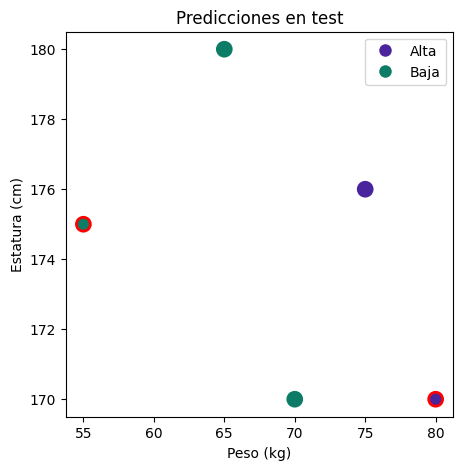

In [36]:
# Cargamos los datos de test (peso y estatura de cada persona de test)
X_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/datos02a_test.csv")  # Update the path

# Cargamos las etiquetas de test (nivel de actividad física de cada persona de test)
y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/datos02a_test_etiquetas.csv")  # Update the path

# El modelo ya está entrenado de antes

# Predecir las clases de las personas de test
y_pred = model_sklearn.predict(X_test)

# Mostrar resultados
print(f"Etiquetas predichas:\t{[dict_clases[i] for i in y_pred]}")
print(f"Etiquetas reales:\t\t{[dict_clases[i] for i in y_test['ActividadFisica']]}")
visualizar_predicciones(X_test, y_test, y_pred, "Predicciones en test",  "Peso (kg)", "Estatura (cm)", dict_clases)

No todas las personas han sido clasificadas correctamente. Ahora (que hay pocos datos) vemos bien cuáles si y cuáles no, ¿pero qué pasa cuando el dataset de test tiene muchos más datos? Hay que medir el rendimiento de alguna forma: mediante métricas de evaluación

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred) # Accuracy
conf_matrix = confusion_matrix(y_test, y_pred) # Matriz de confusión

print(f"Accuracy: {accuracy:.3f}")
print(f"Matriz de confusión:\n{conf_matrix}")

Accuracy: 0.600
Matriz de confusión:
[[1 1]
 [1 2]]


**EJERCICIO:** modelo
 con datos02b_train.csv (10 minutos)

Carga los datos de datos02b_train.csv y entrena un modelo KNN para hacer predicciones con los
 vecinos más cercanos. Utiliza este modelo para predecir datos02a_test.csv y obtén el número de instancias bien clasificadas.

¿Mejoran o empeoran las predicciones respecto al modelo con los datos datos02a_train.csv?

**1. Cargar los datos de entrenamiento (datos02b_train.csv):**

In [39]:
df_train_b = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/datos02b_train.csv")

# Separar las variables (X) de las etiquetas (y)
X_train_b = df_train_b[["Peso", "Estatura"]]
y_train_b = df_train_b["ActividadFisica"]

**2. Entrenar el modelo KNN con los nuevos datos:**



In [40]:
# Crear el modelo con k=3 (igual que antes)
model_b = KNeighborsClassifier(n_neighbors=3)

# Entrenar el modelo con los nuevos datos
model_b.fit(X_train_b, y_train_b)

KNeighborsClassifier(n_neighbors=3)

**3. Predecir con los datos de prueba (datos02a_test.csv):**

In [41]:
# Cargar los datos de prueba (datos02a_test.csv)
X_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/datos02a_test.csv")

# Predecir las clases de las personas de test
y_pred_b = model_b.predict(X_test)

**4. Obtener el número de instancias bien clasificadas:**

In [42]:
# Cargar las etiquetas reales de test (datos02a_test_etiquetas.csv)
y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/datos02a_test_etiquetas.csv")

# Calcular la precisión (accuracy)
accuracy_b = accuracy_score(y_test, y_pred_b)

print(f"Accuracy con datos02b_train: {accuracy_b:.3f}")

Accuracy con datos02b_train: 0.400


**5. Comparar con el modelo anterior:**

In [43]:
print(f"Accuracy con datos02a_train: {accuracy:.3f}")  # Accuracy del modelo anterior
print(f"Accuracy con datos02b_train: {accuracy_b:.3f}")

if accuracy_b > accuracy:
    print("Las predicciones mejoran con datos02b_train.csv")
elif accuracy_b < accuracy:
    print("Las predicciones empeoran con datos02b_train.csv")
else:
    print("Las predicciones son iguales con ambos conjuntos de datos")

Accuracy con datos02a_train: 0.600
Accuracy con datos02b_train: 0.400
Las predicciones empeoran con datos02b_train.csv


**Conclusión:**
Al ejecutar este código, podrás observar si el modelo entrenado con datos02b_train.csv produce mejores o peores predicciones en comparación con el modelo anterior. La diferencia en la precisión te dará la respuesta. Espero que esto te ayude a comprender mejor el proceso de entrenamiento y evaluación de modelos KNN.

## 3 Preprocesamiento de datos

Hasta ahora hemos utilizado los datos directamente al cargarlos. Esto casi nunca es lo correcto, normalmente habrá que revisar los datos de entrenamiento y preprocesarlos antes de entrenar un modelo con ellos. Por ejemplo:

Escalado de características.
Si no tienen el mismo rango, las distancias, etc. se ven afectadas.
Tratamiento de características categóricas.
La mayoría de modelos trabajan con características numéricas, por lo que habrá que codificar las variables cuyo valor no sea numérico.
Tratamiento de valores faltantes.
Valores que no existen para alguna instancia en los datos (porque se haya perdido la medida, etc.).
Tratamiento de outliers.
Datos que son atípicos y no son útiles para el modelo (pueden deberse a errores en medidas, etc.). En este curso no los vamos a ver porque no nos da tiempo. En sklearn disponéis de varias herramientas para tratarlos.
Selección de características.
No siempre todas son relevantes para el problema.

### 3.1 Escalado de características
Vamos a cargar las dos características adicionales del dataset datos02a_train.csv: la edad de la persona y su porcentaje de grasa corporal. Y visualizamos estas dos últimas variables

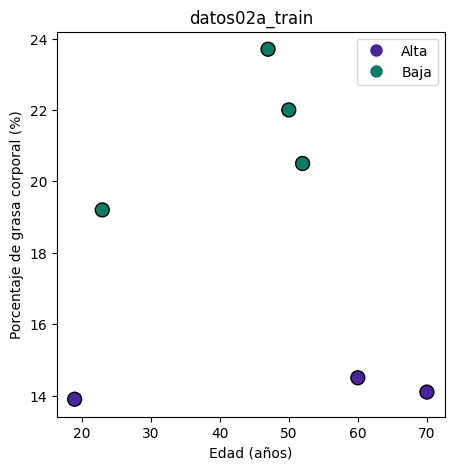

In [44]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/datos02a_train.csv")

# Separar las variables (X) de las etiquetas (y)
X_train = df[["Edad", "PctGrasaCorporal"]]
y_train = df["ActividadFisica"]

# Visualizar porcentaje de grasa corporal en función de la edad
x_range, y_range = visualizar_datos(X_train, y_train, "datos02a_train", "Edad (años)", "Porcentaje de grasa corporal (%)", dict_clases)

¿Qué pasa si ahora queremos predecir el nivel de actividad física de una persona con
 años y un
 de grasa corporal? Vamos a utilizar
: parece que los tres vecinos más cercanos serían las tres personas con baja actividad de la esquina superior derecha.

In [45]:
model = KNN(k=3, dist_func=euclidean_distance)
model.fit(X_train=X_train, y_train=y_train)

X_new = np.array([65, 23.4]) # Nueva persona a clasificar

ani_knn_3 = AnimateKNN(knn=model, X_new=X_new, colors=colors, col_names_train=["Edad (años)", "Porcentaje de grasa corporal (%)"], class_name="Actividad Física")
plt.close()
HTML(ani_knn_3.to_jshtml())

El problema es que la edad y el porcentaje de grasa corporal tienen diferentes escalas! Esto se puede solucionar estandarizando los datos, para que todas las características tengan la misma media y desviación estandar: 1. Todas las características tendrán media
. 2. Todas las características tendrán desviación estándar
.

Para ello, sklearn proporciona la clase StandardScaler dentro del módulo sklearn.preprocessing, que genera un objeto que nos permite aprender y realizar las transformaciones de la siguiente forma:

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

NOTA: Debemos estandarizar cada característica por separado
StandardScaler actúa independientemente en cada característica:

Para cada columna (característica):
Obtiene su media y su desviación estándar.
Resta la media y divide por la desviación estándar.
Almacena la media y la desviación estándar para poder hacer transformaciones en el futuro.

Ahora la situación habrá cambiado:

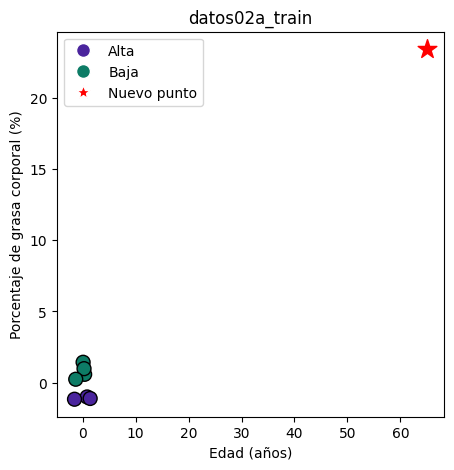

In [47]:
x_range, y_range = visualizar_datos(X_train_scaled, y_train, "datos02a_train", "Edad (años)", "Porcentaje de grasa corporal (%)", dict_clases, X_new)

Pero todavía falta escalar el dato nuevo. **La media y desviación estándar** deben ser las de entrenamiento, ya que no podemos sacar información de los datos de test.

Ahora la predicción será diferente:

In [48]:
model = KNN(k=3, dist_func=euclidean_distance)
model.fit(X_train=X_train_scaled, y_train=y_train)

# Escalar el nuevo punto!!
X_new_scaled = scaler.transform([X_new])[0]

ani_knn_4 = AnimateKNN(knn=model, X_new=X_new_scaled, colors=colors, col_names_train=["Edad (años)", "Porcentaje de grasa corporal (%)"], class_name="Actividad Física")
plt.close()
HTML(ani_knn_4.to_jshtml())

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### 3.2 Tratamiento de características categóricas
Hasta ahora hemos trabajado con variables numéricas. Pero, ¿qué pasa si tenemos variables categóricas? Por ejemplo, si queremos utilizar el estado civil de las personas como información adicional.

In [50]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/datos04_train.csv")

# Separar las variables (X) de las etiquetas (y)
X_train = df.drop(columns=["ActividadFisica"]) # Quitar la columna de clase
y_train = df["ActividadFisica"]

print(f"Valores de la característica EstadoCivil: {X_train['EstadoCivil'].unique()}")

Valores de la característica EstadoCivil: ['casado' 'soltero' 'divorciado']


Si intentamos escalar datos no numéricos, obtendremos un error

In [51]:
# Escalar las variables numéricas
scaler = StandardScaler()

try:
    X_train_scaled = scaler.fit_transform(X_train)
except ValueError as e:
    print("ValueError:", e)

ValueError: could not convert string to float: 'casado'


También obtendremos un error si entrenamos un modelo numérico (como
k-NN) directamente.

In [52]:
# Escalar las variables numéricas
model = KNeighborsClassifier(n_neighbors=3)

try:
    model_sklearn.fit(X_train, y_train) # Tratar de entrenar el modelo
except ValueError as e:
    print("ValueError:", e)

ValueError: could not convert string to float: 'casado'


La técnica más común para tratar variables categóricas es **One-Hot encoding:**

Para cada columna (característica) categórica:
Se obtiene los valores únicos de la columna.
Se crea una nueva columna (una nueva característica) para cada valor único.
Para cada instancia del dataset y cada columna nueva:
Se asigna un
 si la instancia tiene ese valor y un
 en caso contrario.
En sklearn se puede hacer con la clase OneHotEncoder.

Primero buscamos qué variables son categóricas y cuáles numéricas:

In [54]:
# Variables categóricas
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()

# Variables numéricas
numeric_features = X_train.select_dtypes(include=["number"]).columns.tolist()

print(f"Las variables numéricas son: {numeric_features}")
print(f"Las variables categóricas son: {categorical_features}")
print(f"Valores de la característica EstadoCivil: {X_train['EstadoCivil'].unique()}")

Las variables numéricas son: ['Peso', 'Estatura', 'Edad', 'PctGrasaCorporal']
Las variables categóricas son: ['EstadoCivil']
Valores de la característica EstadoCivil: ['casado' 'soltero' 'divorciado']


Y ahora queremos hacer OneHotEncoding de las variables categóricas y estandarizar las numéricas. Con ColumnTransformer podemos especificar que tipo de preprocesamiento realizamos sobre cada característica:

In [55]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Estandarizar las numéricas y One-Hot encoding de las categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(), categorical_features)
    ]
)

# Preprocesar los datos de entrenamiento
X_train_processed = preprocessor.fit_transform(X_train)

# Ver cómo han cambiado los datos ahora
print("La primera instancia era originalmente:")
print(X_train.iloc[0]) # Esto es un DataFrame de Pandas

print("\nLa primera instancia ahora es:")
X_train_processed[0] # Esto es un array de NumPy

La primera instancia era originalmente:
Peso                  80.1
Estatura             172.5
Edad                    74
PctGrasaCorporal      17.8
EstadoCivil         casado
Name: 0, dtype: object

La primera instancia ahora es:


array([0.55679471, 0.30659255, 1.68853421, 0.46309459, 1.        ,
       0.        , 0.        ])

NOTA: ¿Cómo sé qué columnas corresponden a qué variables?


In [56]:
def get_onehot_columns(numeric_col_names: list, ohe: OneHotEncoder) -> np.ndarray:
    # Obtener los nombres de las columnas categóricas tras el OneHotEncoding
    categorical_column_names = ohe.get_feature_names_out(categorical_features)

    # Concatenar ambos conjuntos de nombres de columnas
    return np.concatenate([numeric_col_names, categorical_column_names])

ohe = preprocessor.named_transformers_["cat"]  # Acceder al OneHotEncoder

# Convertir el resultado a un DataFrame para visualizarlo con nombres de columnas
X_train_processed_df = pd.DataFrame(X_train_processed, columns=get_onehot_columns(numeric_features, ohe))

# Mostrar la primera fila del DataFrame resultante
print("Primera instancia del dataset:\n")
print(X_train_processed_df.head(1))

Primera instancia del dataset:

       Peso  Estatura      Edad  PctGrasaCorporal  EstadoCivil_casado  \
0  0.556795  0.306593  1.688534          0.463095                 1.0   

   EstadoCivil_divorciado  EstadoCivil_soltero  
0                     0.0                  0.0  


Están en el mismo orden que en el DataFrame original, pero las columnas categóricas se han expandido con cada uno de sus valores originales.

### 3.3 Imputacion de valores faltantes
Los valores faltantes (missing values) ocurren cuando no se dispone del valor de una característica para una instancia en particular.

Hay múltiples técnicas que se pueden emplear para tratar este tipo de errores en el dataset, ya que muchos algoritmos no funcionan con valores desconocidos. Una de las más comunes es la imputación: rellenar los valores faltantes siguiendo una regla. En sklearn es posible gracias a la clase SimpleImputer:

La estrategia de imputación (cómo se obtiene el valor nuevo que sustituye al faltante) puede ser:

mean: la media de los valores de la columna. Solo valores numéricos.
median: la mediana de los valores de la columna. Solo valores numéricos.
most_frequent: el valor más frecuente de la columna. Para strings y numéricos.
constant: un valor constante que se especifica con el parámetro fill_value. Para strings y numéricos.
Para las variables numéricas:

In [57]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy="mean")  # default

print(imp.fit_transform([[1, 2], [np.nan, 3], [7, 6]]))

# Si queremos aplicar la misma imputación sobre otro conjunto de datos
print(imp.transform([[np.nan, 2], [6, np.nan], [7, 6]]))

[[1. 2.]
 [4. 3.]
 [7. 6.]]
[[4.         2.        ]
 [6.         3.66666667]
 [7.         6.        ]]


Para las variables categóricas:

In [58]:
df = pd.DataFrame([ ["a",        "x"],
                    [np.nan,     "y"],
                    ["a",     np.nan],
                    ["b",        "y"]],
                    dtype="category")

imp = SimpleImputer(strategy="most_frequent")

print(imp.fit_transform(df))

[['a' 'x']
 ['a' 'y']
 ['a' 'y']
 ['b' 'y']]


**EJERCICIO: preprocesamiento de datos (15 minutos)**

El archivo MathLearningDataset.csv contiene datos modificados a partir del dataset Assessing Mathematics Learning in Higher Education, disponible publicamente en el UCI Machine Learning Repository. Es un dataset con datos de estudiantes y preguntas de examen, y la variable objetivo es si la respuesta a cada pregunta es correcta o no (columna Type of Answer).

Carga los datos y visualiza las primeras filas para conocer qué características tiene.
Separa los datos de sus etiquetas.
Analiza las columnas y comprueba qué técnicas de preprocesamiento son necesarias.
Aplica las técnicas de preprocesamiento necesarias.

**Cargar los datos y visualizar las primeras filas:**

In [62]:
import pandas as pd

# Cargar el dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/MathLearningDataset.csv")

# Visualizar las primeras filas
df.head()

Student ID Student Country  Question ID  Type of Answer Question Level  \
0         647         Ireland           77               0          Basic   
1          41        Portugal           77               1          Basic   
2         340        Portugal           77               1          Basic   
3         641           Italy           77               0          Basic   
4         669        Portugal           77               1          Basic   

        Topic    Subtopic  Student Age  Response Time (s)  
0  Statistics  Statistics         28.0               53.0  
1  Statistics  Statistics         20.0               74.0  
2  Statistics  Statistics         27.0               64.0  
3  Statistics  Statistics         18.0               42.0  
4  Statistics  Statistics         18.0               30.0

Paso 2: Separar los datos de sus etiquetas



In [77]:
# Separar las variables (X) de las etiquetas (y)
X = df.drop(columns=["Type of Answer"])  # Quitar la columna de clase
y = df["Type of Answer"]

**Paso 3: Analizar las columnas y determinar el preprocesamiento necesario**

In [69]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9546 entries, 0 to 9545
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Student ID         9546 non-null   int64  
 1   Student Country    9463 non-null   object 
 2   Question ID        9546 non-null   int64  
 3   Type of Answer     9546 non-null   int64  
 4   Question Level     9461 non-null   object 
 5   Topic              9473 non-null   object 
 6   Subtopic           9474 non-null   object 
 7   Student Age        9460 non-null   float64
 8   Response Time (s)  9468 non-null   float64
dtypes: float64(2), int64(3), object(4)
memory usage: 671.3+ KB


Student ID  Question ID  Type of Answer  Student Age  \
count  9546.000000  9546.000000     9546.000000  9460.000000   
mean    775.402263   478.912319        0.468259    22.908879   
std     460.590559   249.244061        0.499018     4.152163   
min      26.000000    77.000000        0.000000    17.000000   
25%     380.000000   323.000000        0.000000    20.000000   
50%     885.000000   428.000000        0.000000    22.000000   
75%    1219.000000   571.000000        1.000000    25.000000   
max    1565.000000  1549.000000        1.000000    40.000000   

       Response Time (s)  
count        9468.000000  
mean           63.741234  
std            20.237755  
min            27.000000  
25%            49.000000  
50%            63.000000  
75%            78.000000  
max           147.000000

**Paso 4: Aplicar las técnicas de preprocesamiento**



In [81]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Definir las transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["Student Age", "Response Time (s)"]),  # Columnas numéricas
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ["Student Country", "Question Level", "Topic", "Subtopic"]),  # Columnas categóricas
        ("impute_num", SimpleImputer(strategy="mean"), ["Student Age", "Response Time (s)"]),
        ("impute_cat", SimpleImputer(strategy="most_frequent"), ["Student Country", "Question Level", "Topic", "Subtopic"]),
    ]
)

# Aplicar las transformaciones a los datos
X_processed = preprocessor.fit_transform(X)
# Imprime
print(X_processed)

[[1.2262018971700026 -0.5307802753233711 1.0 ... 'Basic' 'Statistics'
  'Statistics']
 [-0.700606781411157 0.5069390562465244 0.0 ... 'Basic' 'Statistics'
  'Statistics']
 [0.9853508123473577 0.012786993594193174 0.0 ... 'Basic' 'Statistics'
  'Statistics']
 ...
 [-0.459755696588512 -0.38253465652767177 0.0 ... 'Basic'
  'Fundamental Mathematics' 'Algebraic expressions']
 [-0.459755696588512 0.062202199859426294 0.0 ... 'Basic'
  'Fundamental Mathematics' 'Algebraic expressions']
 [-0.459755696588512 -1.2225931630366347 0.0 ... 'Basic'
  'Fundamental Mathematics' 'Algebraic expressions']]


## 4 Pipelines
Hasta ahora hemos visto cómo preprocesar los datos de forma manual, haciendo paso a paso todo nosotros. sklearn proporciona una forma más sencilla de hacerlo: los pipelines. Los pipelines representan la sequencia de pasos que se aplican a los datos: métodos de preprocesamiento y modelos de predicción.

Primero cargamos los datos como siempre:

In [85]:
# Cargar el conjunto de datos
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/datos05_train.csv")

# Separar las variables (X) de las etiquetas (y)
X_train = df.drop(columns=["ActividadFisica"]) # Quitar la columna de clase
y_train = df["ActividadFisica"]

Comprobar el número de instancias y si existen valores faltantes:

In [86]:
print(f"Nº de instancias {len(X_train)}\n")
X_train.info()

Nº de instancias 1500

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Peso              1480 non-null   float64
 1   Estatura          1484 non-null   float64
 2   Edad              1484 non-null   float64
 3   PctGrasaCorporal  1491 non-null   float64
 4   EstadoCivil       1486 non-null   object 
dtypes: float64(4), object(1)
memory usage: 58.7+ KB


Comprobar el rango de valores de las variables numéricas:

In [87]:
X_train.describe()

Peso     Estatura         Edad  PctGrasaCorporal
count  1480.000000  1484.000000  1484.000000       1491.000000
mean     73.341659   168.992790    46.064016         16.425865
std      21.757760    11.276414    16.566524          7.176750
min      40.000000   139.300000    18.000000          5.000000
25%      61.175000   160.900000    32.000000         13.100000
50%      71.400000   168.500000    45.000000         15.900000
75%      81.600000   176.550000    60.250000         18.800000
max     298.361170   201.300000    74.000000         98.042779

Como hay valores faltantes, características categóricas y las características numéricas no están en el mismo rango, tenemos que realizar un preprocesamiento de los datos. En nuestro caso querríamos aplicar los siguientes pasos:

Características categóricas:
Imputar valores faltantes con el valor más frecuente.
One-Hot encoding de cada característica.
Características numéricas:
Imputar valores faltantes con la media.
Estandarizar los valores de cada columna.
Sobre todas las características preprocesadas:
Entrenar un modelo
-NN.
Y además cuando queramos predecir nuevos datos, también tendremos que aplicar los mismos pasos de preprocesamiento (el paso 3.1. se sustituye por predicción).

La clase Pipeline de sklearn.pipeline permite integrar todos los anteriores pasos en un único “bloque”.

In [88]:
from sklearn.pipeline import Pipeline

categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist() # Variables categóricas
numeric_features = X_train.select_dtypes(include=["number"]).columns.tolist() # Variables numéricas

# Primer pipeline: preprocesar las variables numéricas
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())])

# Segundo pipeline: preprocesar las variables categóricas
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

# Create a pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Peso', 'Estatura', 'Edad',
                                  'PctGrasaCorporal']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['EstadoCivil'])])

Este preprocesador hay que entrenarlo sobre los datos de entrenamiento, y luego transformar tanto los datos de entrenamiento como los de test.

In [89]:
# Preprocesar los datos de entrenamiento
X_train_processed = preprocessor.fit_transform(X_train)

# Ver cómo han cambiado los datos ahora
print("La primera instancia era originalmente:")
print(X_train.iloc[0]) # Esto es un DataFrame de Pandas

print("\nLa primera instancia después del preprocesamiento es:")
X_train_processed[0] # Esto es un array de NumPy

La primera instancia era originalmente:
Peso                  80.1
Estatura             172.5
Edad                  74.0
PctGrasaCorporal      17.8
EstadoCivil         casado
Name: 0, dtype: object

La primera instancia después del preprocesamiento es:


array([0.31281494, 0.31279935, 1.69592889, 0.19211176, 1.        ,
       0.        , 0.        ])

Ahora que tenemos el paso de preprocesamiento creado, falta completar el pipeline con el modelo de predicción. Esto permitirá crear un único objeto Pipeline que se encargará de todo el proceso de preprocesamiento y predicción de forma integrada.

In [90]:
# Incluir el clasificador en el pipeline
model = KNeighborsClassifier(n_neighbors=3)

# Crear el pipeline final
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor), # Primer paso: preprocesador los datos
    ("classifier", model)           # Segundo paso: clasificar los datos
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Peso', 'Estatura', 'Edad',
                                                   'PctGrasaCorporal']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['EstadoCivil'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])

Ahora podemos entrenar y predecir de forma integrada.

In [91]:
# Entrenar modelos con los datos de entrenamiento
pipeline.fit(X_train, y_train)
# Ahora no se puede hacer pipeline.fit_transform(X_train) porque KNeighborsClassifier no tiene método transform

# Podemos predecir las etiquetas de los datos de entrenamiento
y_train_pred = pipeline.predict(X_train)

# Y medir su accuracy
accuracy = accuracy_score(y_train, y_train_pred) # Accuracy
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.977


NOTA: ¿Por qué el accuracy es tan alto?
Hemos entrenado el pipeline sobre el conjunto de entrenamiento, y luego hemos medido el accuracy del modelo sobre el mismo conjunto de datos. Como estos datos ya se le habían presentado al modelo durante el entrenamiento, predecirlos es una tarea fácil.

Esta es la razón por la cuál no se deben utilizar datos de test en ningún paso del entrenamiento del modelo. En la siguiente sección veremos cómo evaluar el modelo de forma correcta.

**EJERCICIO: preprocesamiento de datos (10 minutos)**

Reproduce el ejercicio de preprocesamiento del MathLearningDataset.csv utilizando pipelines.

Carga los datos.
Separa los datos de sus etiquetas.
Eliminar las columnas que contienen IDs.
Imputa los valores faltantes.
Estandariza las columna numéricas.
Aplica OneHotEncoding a las columnas categóricas.

**1. Cargar los datos**



In [92]:
import pandas as pd

# Cargar el dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/MathLearningDataset.csv")

# Visualizar las primeras filas
df.head()

Student ID Student Country  Question ID  Type of Answer Question Level  \
0         647         Ireland           77               0          Basic   
1          41        Portugal           77               1          Basic   
2         340        Portugal           77               1          Basic   
3         641           Italy           77               0          Basic   
4         669        Portugal           77               1          Basic   

        Topic    Subtopic  Student Age  Response Time (s)  
0  Statistics  Statistics         28.0               53.0  
1  Statistics  Statistics         20.0               74.0  
2  Statistics  Statistics         27.0               64.0  
3  Statistics  Statistics         18.0               42.0  
4  Statistics  Statistics         18.0               30.0

**2. Separar los datos de sus etiquetas**



In [93]:
# Separar las variables (X) de las etiquetas (y)
X = df.drop(columns=["Type of Answer"])  # Quitar la columna de clase
y = df["Type of Answer"]

**3. Eliminar las columnas que contienen IDs**



In [94]:
# Eliminar las columnas 'Student ID' y 'Question ID'
X = X.drop(columns=["Student ID", "Question ID"])

**4. Crear el pipeline de preprocesamiento**



In [95]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Variables categóricas
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

# Variables numéricas
numeric_features = X.select_dtypes(include=["number"]).columns.tolist()

# Pipeline para las variables numéricas
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

# Pipeline para las variables categóricas
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
    ]
)

# Pipeline de preprocesamiento completo
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

**5. Aplicar el pipeline a los datos**


In [96]:
# Preprocesar los datos de entrenamiento
X_processed = preprocessor.fit_transform(X)

# Imprimir los datos preprocesados (opcional)
print(X_processed)

[[ 1.23176293 -0.53296215  1.         ...  0.          1.
   0.        ]
 [-0.70378415  0.50902293  0.         ...  0.          1.
   0.        ]
 [ 0.98981955  0.01283956  0.         ...  0.          1.
   0.        ]
 ...
 [-0.46184077 -0.38410714  0.         ...  0.          0.
   0.        ]
 [-0.46184077  0.06245789  0.         ...  0.          0.
   0.        ]
 [-0.46184077 -1.22761886  0.         ...  0.          0.
   0.        ]]
